In [1]:
import torch.nn as nn
import torch
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.optim import Adam
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2


In [2]:
import pytorch_ssim

In [3]:
def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn
    )
    return model

In [4]:
def conv_trans_block(in_dim,out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn
    )
    return model

In [5]:
def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

In [6]:
def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim)
    )
    return model

In [7]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
        )
        
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [8]:
batch_size = 16
img_size = 256
in_dim = 1
out_dim = 3
num_filters = 16


In [9]:
# preprocessing
transform=transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(256),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 이미지 값 [-1,1] 사이로 변환
                        ])
transform_gray=transforms.Compose([
                            transforms.Grayscale(num_output_channels=1),
                            transforms.Resize(256),
                            transforms.CenterCrop(256),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5), (0.5)), # 이미지 값 [-1,1] 사이로 변환
                        ])

In [10]:
dataset_color = datasets.ImageFolder("./colorization_data/color_image", transform=transform)
dataset_gray = datasets.ImageFolder("./colorization_data/color_image", transform=transform_gray)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
dataset_color_train , dataset_color_test = train_test_split(dataset_color, test_size=0.2, random_state=42)
dataset_gray_train, dataset_gray_test = train_test_split(dataset_gray,test_size=0.2, random_state=42)

In [13]:
train_color_loader = DataLoader(dataset_color_train, batch_size=batch_size)
train_gray_loader = DataLoader(dataset_gray_train, batch_size=batch_size)
test_color_loader = DataLoader(dataset_color_test, batch_size=batch_size)
test_gray_loader = DataLoader(dataset_gray_test , batch_size=batch_size)

In [14]:
def show_tensor_images(image_tensor, num_images=25, size=(3,64,64)):
    '''
    image_tensor : 텐서로 구성된 이미지
    num_images : 이미지 개수
    size : 이미지 크기
    -> 이미지를 화면에 보여준다.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = v_utils.make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.show()

In [15]:
def PSNRloss(mseloss):
    return 20 * torch.log10(255.0 / torch.sqrt(mseloss))

In [17]:
display_step = 50
Learning_rate = 0.0001
n_epochs = 170

Unet = UnetGenerator(in_dim=in_dim, out_dim=out_dim,num_filter=num_filters).to(device)
loss_func = pytorch_ssim.SSIM()

optimizer = torch.optim.Adam(Unet.parameters(), lr=Learning_rate)


------Initiating U-Net------



In [ ]:
cur_step = 0
display_step = 100
n_epochs = 70
for epoch in range(n_epochs):
    SSIM_SCORE = 0
    cur_step = 0
    print(f'epoch: {epoch + 1}/{n_epochs}')
    for [color , _],[gray , _] in tqdm(zip(train_color_loader, train_gray_loader)):
        optimizer.zero_grad()
        gray = gray.to(device)
        color = color.to(device)

        output = Unet(gray)
        
        loss = 1 - loss_func(output, color)

        loss.backward()
        optimizer.step()
        cur_step += 1
        SSIM_SCORE += loss.item()

    
    print(f"Step {cur_step}: SSIM score : {1 - SSIM_SCORE/cur_step}")
    show_tensor_images(output, num_images=16, size=(3,256,256))
    show_tensor_images(color,num_images=16, size=(3,256,256))
    torch.save(Unet, "./model/colorization_SSIM.pt")



In [20]:
def save_tensor_images(image_tensor, num_images=25, size=(3,64,64), dir="", num=0):
    '''
    image_tensor : 텐서로 구성된 이미지
    num_images : 이미지 개수
    size : 이미지 크기
    -> 이미지를 화면에 보여준다.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    #image_grid = v_utils.make_grid(image_unflat[:num_images], nrow=4)
    #print(image_unflat[0].permute(1,2,0).squeeze().shape)
    for i in range(num_images):
        image_name = f'{num}_{i}.jpg'
        v_utils.save_image(image_unflat[i].squeeze(), os.path.join(dir,image_name))

0it [00:00, ?it/s]

Step 1: SSIM score : 0.06919835805892945


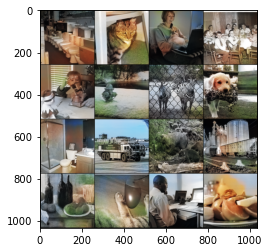

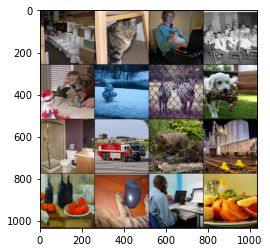

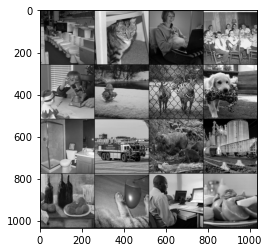

Step 11: SSIM score : 0.7314775586128235


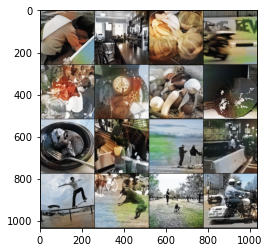

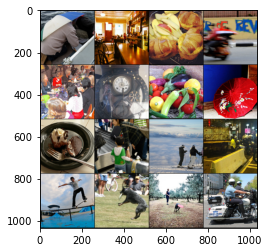

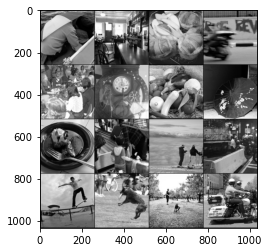

Step 11: SSIM score : 0.7304501116275788


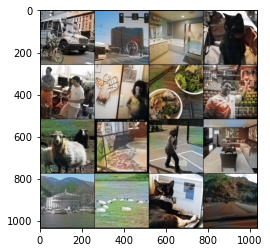

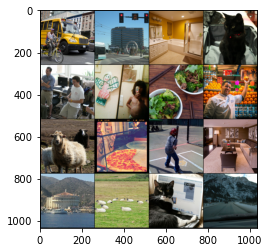

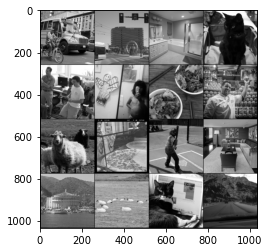

Step 11: SSIM score : 0.7431445062160492


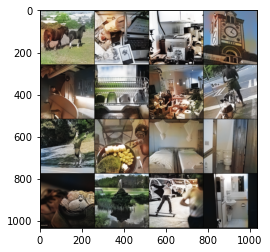

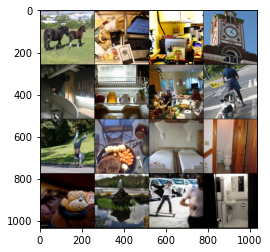

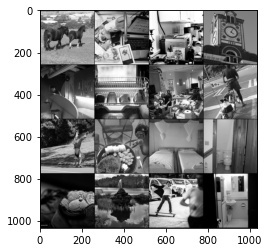

Step 11: SSIM score : 0.7427257537841797


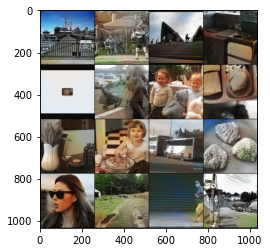

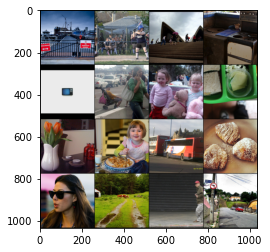

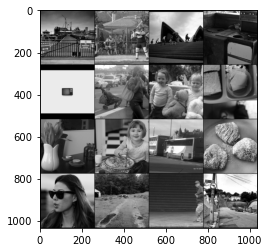

Step 11: SSIM score : 0.7215684056282043


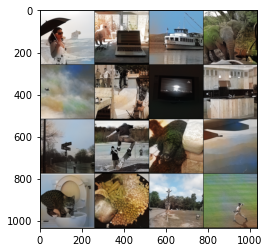

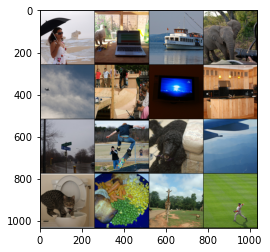

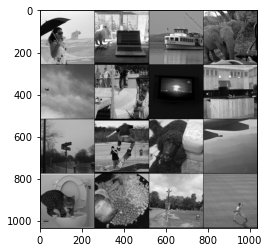

Step 11: SSIM score : 0.7446075916290283


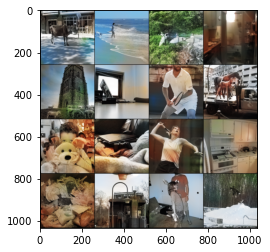

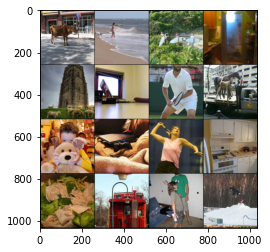

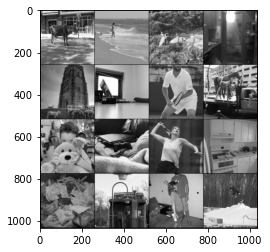

Step 11: SSIM score : 0.741027170419693


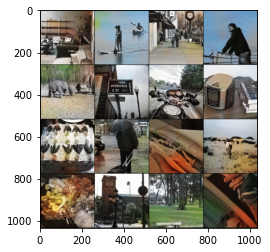

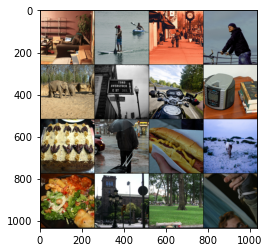

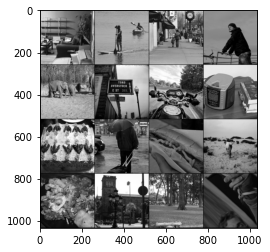

Step 11: SSIM score : 0.7475634694099427


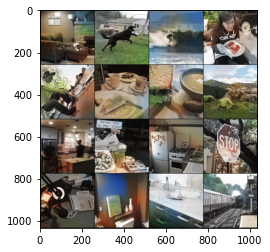

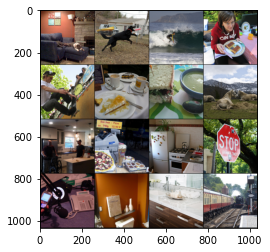

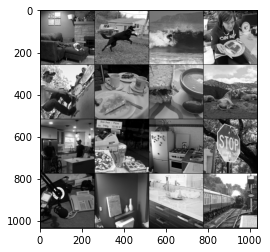

Step 11: SSIM score : 0.7355744540691376


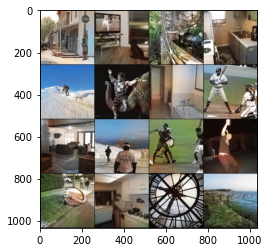

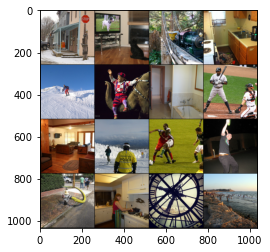

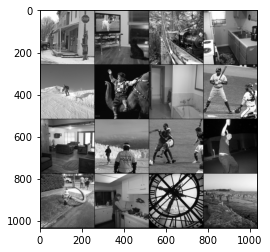

Step 11: SSIM score : 0.7444608390331269


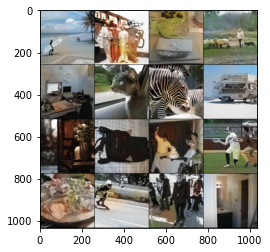

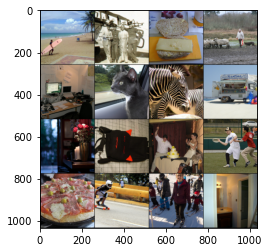

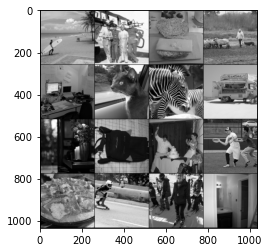

Step 11: SSIM score : 0.7339861154556274


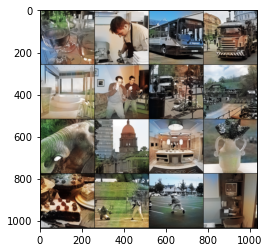

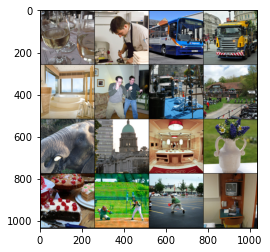

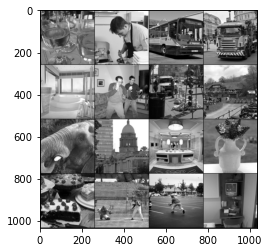

Step 11: SSIM score : 0.736364197731018


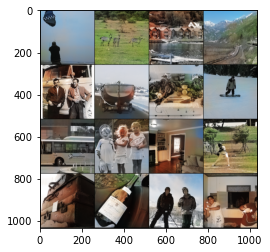

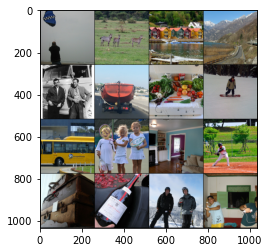

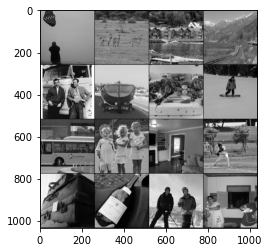

Step 11: SSIM score : 0.730373215675354


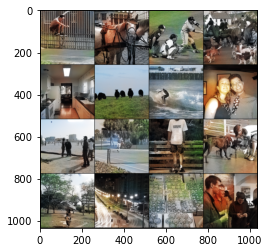

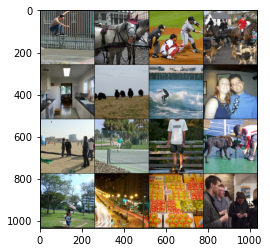

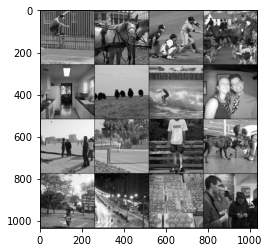

In [27]:
gray_path = "./output_image_SSIM/gray/"
color_path = "./output_image_SSIM/color/"
output_path = "./output_image_SSIM/output/"

gray_image = []
color_image = []
output_image = []
display_step = 10
mean_loss = 0
with torch.no_grad():
    cur_step = 1
    for i,[[color, _] ,[gray, _]] in tqdm(enumerate(zip(test_color_loader, test_gray_loader))):
        color = color.to(device)
        gray = gray.to(device)

        output = Unet(gray)
        ''''
        gray_image.append(torch.squeeze(gray.cpu().data))
        color_image.append(torch.squeeze(color.cpu().data))
        output_image.append(torch.squeeze(output.cpu().data))
        '''
        
        mean_loss += loss_func(output, color).item()
        
        if i%display_step == 0:
            print(f"Step {cur_step}: SSIM score : {mean_loss/display_step}")
            show_tensor_images(output, num_images=16, size=(3,256,256))
            show_tensor_images(color,num_images=16, size=(3,256,256))
            show_tensor_images(gray,num_images=16, size=(256,256))
            cur_step = 1;
            mean_loss = 0;
        '''
        save_tensor_images(gray,num_images=16, size=(256,256),dir=gray_path,num=cur_step)
        save_tensor_images(color,num_images=16, size=(3,256,256),dir=color_path,num=cur_step)
        save_tensor_images(output,num_images=16, size=(3,256,256),dir=output_path,num=cur_step)
        '''
        cur_step += 1

In [ ]:
torch.save(Unet,"./model/colorization_GAN_200_Unet.pt")
torch.save(disc, "./model/colorization_GAN_200_disc.pt")